<a href="https://colab.research.google.com/github/mattfarrow1/7331-machine-learning-1/blob/main/MiniProject_Group4_mb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project: SVM & Logistic Regression Classification

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

## Logistic Regression & Support Vector Machine Models

[50 points] Create a logistic regression model and a support vector machine model for the
classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.

### Prep Data

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import altair as alt

# Due to the way these columns are formatted, we want to keep the leading zeros during our import. Later on will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
# Read in the data using Pandas
#airlines = pd.read_csv('../Data/airlines.csv')
#airports = pd.read_csv('../Data/airports.csv')
#flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

# Convert string columns to datetime
cols = [#"SCHEDULED_DEPARTURE", 
   #"DEPARTURE_TIME", 
   "WHEELS_OFF",  
   "WHEELS_ON"] 
   #"SCHEDULED_ARRIVAL", 
   #"ARRIVAL_TIME"]

df[cols] = df[cols].apply(pd.to_datetime, format = '%H%M', errors='coerce')

# Convert YMD into a single date
# Source: https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month
#df['FLIGHT_DATE'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df.YEAR, df.MONTH, df.DAY)])

#convert time to numeric for binning of the other times
cols = ["SCHEDULED_DEPARTURE", 
   "DEPARTURE_TIME", 
   #"WHEELS_OFF",  
   #"WHEELS_ON", 
   "SCHEDULED_ARRIVAL", 
   "ARRIVAL_TIME"]

df[cols] = df[cols].apply(pd.to_numeric)

In [3]:
#df.info()

### Create new variables

In [4]:
#convert times into morning, afternoon, and evening as most models cannot handle timestamps

cut_labels = ['overnight', 'morning', 'afternoon', 'evening']
cut_bins = [0, 400, 1100, 1600, 2359]
df['SCHED_DEPARTURE_TIME'] = pd.cut(df['SCHEDULED_DEPARTURE'], bins=cut_bins, labels=cut_labels, include_lowest=True)
df['ACTUAL_DEPARTURE_TIME'] = pd.cut(df['DEPARTURE_TIME'], bins=cut_bins, labels=cut_labels, include_lowest=True)
df['SCHED_ARRIVAL_TIME'] = pd.cut(df['SCHEDULED_ARRIVAL'], bins=cut_bins, labels=cut_labels, include_lowest=True)
df['ACTUAL_ARRIVAL_TIME'] = pd.cut(df['ARRIVAL_TIME'], bins=cut_bins, labels=cut_labels, include_lowest=True)

df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,1900-01-01 00:15:00,205,194.0,169.0,1448,1900-01-01 04:04:00,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,overnight,evening,morning,morning
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,1900-01-01 00:14:00,280,279.0,263.0,2330,1900-01-01 07:37:00,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,morning
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,1900-01-01 00:34:00,286,293.0,266.0,2296,1900-01-01 08:00:00,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US Airways Inc.,overnight,overnight,morning,morning
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,1900-01-01 00:30:00,285,281.0,258.0,2342,1900-01-01 07:48:00,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,morning
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,1900-01-01 00:35:00,235,215.0,199.0,1448,1900-01-01 02:54:00,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,overnight,overnight,overnight,overnight


In [5]:
#check how many of each bin we have
actual_arrival = df['ACTUAL_ARRIVAL_TIME'].value_counts()
sched_depart = df['SCHED_DEPARTURE_TIME'].value_counts()
actual_depart = df['ACTUAL_DEPARTURE_TIME'].value_counts()
sched_arrival = df['SCHED_ARRIVAL_TIME'].value_counts()

print(actual_arrival, '\n', sched_depart, '\n', actual_depart, '\n', sched_arrival)

evening      2593316
afternoon    1688115
morning      1299286
overnight     143393
Name: ACTUAL_ARRIVAL_TIME, dtype: int64 
 morning      2056248
evening      1971869
afternoon    1768922
overnight      22040
Name: SCHED_DEPARTURE_TIME, dtype: int64 
 evening      1999032
morning      1978882
afternoon    1716939
overnight      37560
Name: ACTUAL_DEPARTURE_TIME, dtype: int64 
 evening      2676736
afternoon    1735865
morning      1317709
overnight      88767
Name: SCHED_ARRIVAL_TIME, dtype: int64


In [6]:
# Bucket Flight Distance
distance_labels = ['Short', 'Medium', 'Long']
distance_bins   = [1, 100, 1000, np.inf]
df['DISTANCE_BUCKET'] = pd.cut(df['DISTANCE'],
                               bins=distance_bins,
                               labels=distance_labels)

# Bucket Arrival Delay
delay_labels = ['Early', 'On-Time', '30-59', '60-89', '90-119', '120+']
delay_bins   = [-np.inf, 0, 30, 60, 90, 120, np.inf]
df['ARRIVAL_DELAY_BUCKET'] = pd.cut(df['ARRIVAL_DELAY'],
                                    bins=delay_bins,
                                    labels=delay_labels)

In [7]:
#check bin sizes
print(df['DISTANCE_BUCKET'].value_counts())
print(df['ARRIVAL_DELAY_BUCKET'].value_counts())

Medium    4102644
Long      1646627
Short       69808
Name: DISTANCE_BUCKET, dtype: int64
Early      3627112
On-Time    1454199
30-59       313605
60-89       133030
120+        114420
90-119       71642
Name: ARRIVAL_DELAY_BUCKET, dtype: int64


In [8]:
# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# Update missing values in times to 0. 
# Will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)

# Change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

# Change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

# Update remaining columns using same logic
cols = ['WHEELS_OFF','WHEELS_ON','ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)
df.loc[(df.WHEELS_OFF != '0'), 'WHEELS_OFF'] = 1
df.loc[(df.WHEELS_ON != '0'), 'WHEELS_ON'] = 1
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1
df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

# Fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']
df[cols] = df[cols].fillna(0)

# Change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0

# Remove remaining null values
df = df.dropna()

In [9]:
# log transformation keeping the 0 in the data sets 
df["DEPARTURE_DELAY_log"] = df["DEPARTURE_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["ARRIVAL_DELAY_Log"]   = df["ARRIVAL_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["DISTANCE_log"]        = df["DISTANCE"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["TAXI_IN_Log"]         = df["TAXI_IN"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["ELAPSED_TIME_log"]    = df["ELAPSED_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["AIR_TIME_log"]        = df["AIR_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5711054 entries, 0 to 5819078
Data columns (total 44 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   YEAR                   int64   
 1   MONTH                  int64   
 2   DAY                    int64   
 3   DAY_OF_WEEK            int64   
 4   AIRLINE_CODE           object  
 5   FLIGHT_NUMBER          int64   
 6   TAIL_NUMBER            object  
 7   ORIGIN_AIRPORT         object  
 8   DESTINATION_AIRPORT    object  
 9   SCHEDULED_DEPARTURE    int64   
 10  DEPARTED               float64 
 11  DEPARTURE_DELAY        float64 
 12  TAXI_OUT               float64 
 13  WHEELS_OFF             object  
 14  SCHEDULED_TIME         object  
 15  ELAPSED_TIME           float64 
 16  AIR_TIME               float64 
 17  DISTANCE               int64   
 18  WHEELS_ON              object  
 19  TAXI_IN                float64 
 20  SCHEDULED_ARRIVAL      int64   
 21  ARRIVED                float64 

In [11]:
pd.set_option('display.max_columns', None)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVED,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,ARRIVAL_DELAY_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,1.0,-11.0,21.0,1,205,194.0,169.0,1448,1,4.0,430,1.0,-22.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,evening,morning,morning,Long,Early,0.0,0.000000,7.278629,1.609438,5.273000,5.135798
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,1.0,-8.0,12.0,1,280,279.0,263.0,2330,1,4.0,750,1.0,-9.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.754053,1.609438,5.634790,5.575949
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,1.0,-2.0,16.0,1,286,293.0,266.0,2296,1,11.0,806,1.0,5.0,0,0,N,0.0,0.0,0.0,0.0,0.0,US Airways Inc.,overnight,overnight,morning,morning,Long,On-Time,0.0,1.791759,7.739359,2.484907,5.683580,5.587249
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,1.0,-5.0,15.0,1,285,281.0,258.0,2342,1,8.0,805,1.0,-9.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.759187,2.197225,5.641907,5.556828
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,1.0,-1.0,11.0,1,235,215.0,199.0,1448,1,5.0,320,1.0,-21.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,overnight,overnight,overnight,Long,Early,0.0,0.000000,7.278629,1.791759,5.375278,5.298317


In [12]:
#scheduled time is not an object but should be numeric. 
df['SCHEDULED_TIME'] = pd.to_numeric(df['SCHEDULED_TIME'])

In [13]:
#create our response variable

#create new column where the arrival_delay > 0 means it's delayed(=1) and if <= 0 it's not delayed(=0)
get_delay = lambda x: 0 if x <= 0 else 1
df['DELAYED'] = df.ARRIVAL_DELAY.apply(get_delay)

In [14]:
#filter to only non-cancelled flights
df = df[df.CANCELLED == 0]

In [15]:
df.shape

(5711054, 45)

In [16]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVED,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,ARRIVAL_DELAY_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log,DELAYED
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,1.0,-11.0,21.0,1,205,194.0,169.0,1448,1,4.0,430,1.0,-22.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,evening,morning,morning,Long,Early,0.0,0.000000,7.278629,1.609438,5.273000,5.135798,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,1.0,-8.0,12.0,1,280,279.0,263.0,2330,1,4.0,750,1.0,-9.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.754053,1.609438,5.634790,5.575949,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,1.0,-2.0,16.0,1,286,293.0,266.0,2296,1,11.0,806,1.0,5.0,0,0,N,0.0,0.0,0.0,0.0,0.0,US Airways Inc.,overnight,overnight,morning,morning,Long,On-Time,0.0,1.791759,7.739359,2.484907,5.683580,5.587249,1
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,1.0,-5.0,15.0,1,285,281.0,258.0,2342,1,8.0,805,1.0,-9.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.759187,2.197225,5.641907,5.556828,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,1.0,-1.0,11.0,1,235,215.0,199.0,1448,1,5.0,320,1.0,-21.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,overnight,overnight,overnight,Long,Early,0.0,0.000000,7.278629,1.791759,5.375278,5.298317,0


### Feature Removals

Here I am removing redundant columns to further reduce the data size. Columns that are being removed:
- `YEAR`: All rows are from 2015, no need to include this.
- `AIRLINE`: We have `AIRLINE_CODE` which is the same information
- `CANCELLATION_REASON` and `CANCELLED`: We are looking at delays only so do not need cancellation details.
- `WHEELS_ON` and `WHEELS_OFF`: We made these binary instead of a time stamp, but this is no longer needed when we are looking at flights being delayed, as these values will all be `1`
- `DEPARTED` and `ARRIVED`: Again, these are binary values and are not needed as all will be equal to `1` after removing the cancelled flights



In [17]:
col_to_drop = ['YEAR','AIRLINE','SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
               'CANCELLED', 'CANCELLATION_REASON', 'WHEELS_ON', 'WHEELS_OFF', 
               'ARRIVED', 'DEPARTED']
df = df.drop(columns = col_to_drop)

In [18]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,ARRIVAL_DELAY_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log,DELAYED
0,1,1,4,AS,98,N407AS,ANC,SEA,-11.0,21.0,205,194.0,169.0,1448,4.0,-22.0,0,0.0,0.0,0.0,0.0,0.0,overnight,evening,morning,morning,Long,Early,0.0,0.000000,7.278629,1.609438,5.273000,5.135798,0
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,-8.0,12.0,280,279.0,263.0,2330,4.0,-9.0,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.754053,1.609438,5.634790,5.575949,0
2,1,1,4,US,840,N171US,SFO,CLT,-2.0,16.0,286,293.0,266.0,2296,11.0,5.0,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,morning,Long,On-Time,0.0,1.791759,7.739359,2.484907,5.683580,5.587249,1
3,1,1,4,AA,258,N3HYAA,LAX,MIA,-5.0,15.0,285,281.0,258.0,2342,8.0,-9.0,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.759187,2.197225,5.641907,5.556828,0
4,1,1,4,AS,135,N527AS,SEA,ANC,-1.0,11.0,235,215.0,199.0,1448,5.0,-21.0,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,overnight,overnight,Long,Early,0.0,0.000000,7.278629,1.791759,5.375278,5.298317,0


### Encoding

In [19]:
#check bin sizes for categorical columns of concern such as TAIL_NUMBER, ORIGIN_AIRPORT, DESTINATION_AIRPORT
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N480HA    3765
N484HA    3722
N488HA    3720
N493HA    3582
N478HA    3575
          ... 
N7LEAA       1
N840MH       1
N121UA       1
N180UA       1
N860NW       1
Name: TAIL_NUMBER, Length: 4896, dtype: int64
ATL      343249
ORD      276379
DFW      232457
DEN      193222
LAX      191776
          ...  
14025         1
11905         1
13459         1
11503         1
11097         1
Name: ORIGIN_AIRPORT, Length: 929, dtype: int64
ATL      343003
ORD      275774
DFW      231694
DEN      192974
LAX      192051
          ...  
11097         1
14222         1
15497         1
14025         1
10666         1
Name: DESTINATION_AIRPORT, Length: 929, dtype: int64


We have 4,896 different airplanes (tail numbers) and 929 different airports. If we one-hot encode all of these, it would create way too many columns. Also, we run the risk of not including a specific airport or tail number in our training data set which would cause an error if it is in our test data set. For that reason, let's set the cut-off to a minimum occurrence of 5 for tail numbers and 10 so that we have a greater likelihood of including it within either the train or test set.

In [20]:
df = df[df.groupby('TAIL_NUMBER').TAIL_NUMBER.transform(len) > 4]
df = df[df.groupby('ORIGIN_AIRPORT').ORIGIN_AIRPORT.transform(len) > 9]
df = df[df.groupby('DESTINATION_AIRPORT').DESTINATION_AIRPORT.transform(len) > 9]
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N480HA    3765
N484HA    3722
N488HA    3720
N493HA    3582
N478HA    3575
          ... 
N119UA       5
N74007       5
N78003       5
N853NW       5
N839MH       5
Name: TAIL_NUMBER, Length: 4844, dtype: int64
ATL      343229
ORD      276372
DFW      232454
DEN      193222
LAX      191756
          ...  
12003        10
13061        10
14574        10
10208        10
12819         8
Name: ORIGIN_AIRPORT, Length: 809, dtype: int64
ATL      342983
ORD      275765
DFW      231688
DEN      192974
LAX      192033
          ...  
12003        10
11778        10
11624        10
11146        10
16218        10
Name: DESTINATION_AIRPORT, Length: 808, dtype: int64


This now reduces to 4,844 unique tail numbers, 809 unique origin airports, and 808 unique destination airports. Hopefully a minimum count of 5 does not give us errors later on.

Next, we will encode these variables. We are not one-hot encoding as there are still way too many values. We know this will add some ordinality to the variables but it is simply not feasible to have 4000+ columns on a 5 million row data set.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5709795 entries, 0 to 5819078
Data columns (total 35 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   MONTH                  int64   
 1   DAY                    int64   
 2   DAY_OF_WEEK            int64   
 3   AIRLINE_CODE           object  
 4   FLIGHT_NUMBER          int64   
 5   TAIL_NUMBER            object  
 6   ORIGIN_AIRPORT         object  
 7   DESTINATION_AIRPORT    object  
 8   DEPARTURE_DELAY        float64 
 9   TAXI_OUT               float64 
 10  SCHEDULED_TIME         int64   
 11  ELAPSED_TIME           float64 
 12  AIR_TIME               float64 
 13  DISTANCE               int64   
 14  TAXI_IN                float64 
 15  ARRIVAL_DELAY          float64 
 16  DIVERTED               int64   
 17  AIR_SYSTEM_DELAY       float64 
 18  SECURITY_DELAY         float64 
 19  AIRLINE_DELAY          float64 
 20  LATE_AIRCRAFT_DELAY    float64 
 21  WEATHER_DELAY          float64 

In [23]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df['ORIGIN_AIRPORT_encode'] = labelencoder.fit_transform(df['ORIGIN_AIRPORT'].astype('str'))

In [27]:
df2 = df[['ORIGIN_AIRPORT','ORIGIN_AIRPORT_encode']]
df2= df2.drop_duplicates(subset=['ORIGIN_AIRPORT'], keep='last')
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809 entries, 845479 to 5709794
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ORIGIN_AIRPORT         809 non-null    object
 1   ORIGIN_AIRPORT_encode  809 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 19.0+ KB


,ORIGIN_AIRPORT,ORIGIN_AIRPORT_encode
845479,STC,595
1443088,CEC,359
1450713,CLD,365
1814744,ILG,456
1828388,CNY,372


In [25]:
df2.rename(columns={'ORIGIN_AIRPORT': 'DESTINATION_AIRPORT'}, inplace=True)
df2.rename(columns={'ORIGIN_AIRPORT_encode': 'DESTINATION_AIRPORT_encode'}, inplace=True)

In [26]:
df = pd.merge(df, df2, on='DESTINATION_AIRPORT', how = 'left')
df.dropna(subset = ["DESTINATION_AIRPORT_encode"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5709785 entries, 0 to 5709794
Data columns (total 37 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   MONTH                       int64   
 1   DAY                         int64   
 2   DAY_OF_WEEK                 int64   
 3   AIRLINE_CODE                object  
 4   FLIGHT_NUMBER               int64   
 5   TAIL_NUMBER                 object  
 6   ORIGIN_AIRPORT              object  
 7   DESTINATION_AIRPORT         object  
 8   DEPARTURE_DELAY             float64 
 9   TAXI_OUT                    float64 
 10  SCHEDULED_TIME              int64   
 11  ELAPSED_TIME                float64 
 12  AIR_TIME                    float64 
 13  DISTANCE                    int64   
 14  TAXI_IN                     float64 
 15  ARRIVAL_DELAY               float64 
 16  DIVERTED                    int64   
 17  AIR_SYSTEM_DELAY            float64 
 18  SECURITY_DELAY              float64 
 19  

In [29]:
df['TAIL_NUMBER_encode'] = labelencoder.fit_transform(df['TAIL_NUMBER'])
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,ARRIVAL_DELAY_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log,DELAYED,ORIGIN_AIRPORT_encode,DESTINATION_AIRPORT_encode,TAIL_NUMBER_encode
0,1,1,4,AS,98,N407AS,ANC,SEA,-11.0,21.0,205,194.0,169.0,1448,4.0,-22.0,0,0.0,0.0,0.0,0.0,0.0,overnight,evening,morning,morning,Long,Early,0.0,0.000000,7.278629,1.609438,5.273000,5.135798,0,319,579.0,1610
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,-8.0,12.0,280,279.0,263.0,2330,4.0,-9.0,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.754053,1.609438,5.634790,5.575949,0,478,537.0,1544
2,1,1,4,US,840,N171US,SFO,CLT,-2.0,16.0,286,293.0,266.0,2296,11.0,5.0,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,morning,Long,On-Time,0.0,1.791759,7.739359,2.484907,5.683580,5.587249,1,580,368.0,415
3,1,1,4,AA,258,N3HYAA,LAX,MIA,-5.0,15.0,285,281.0,258.0,2342,8.0,-9.0,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,morning,Long,Early,0.0,0.000000,7.759187,2.197225,5.641907,5.556828,0,478,505.0,1504
4,1,1,4,AS,135,N527AS,SEA,ANC,-1.0,11.0,235,215.0,199.0,1448,5.0,-21.0,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,overnight,overnight,Long,Early,0.0,0.000000,7.278629,1.791759,5.375278,5.298317,0,579,319.0,2119


In [30]:
#drop columns
col_to_drop = ['TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
df = df.drop(columns = col_to_drop)

For the remaining categorical variables, we can one-hot encode as the number of unique values is significantly less.

In [33]:
categorical_columns = ['AIRLINE_CODE', 'SCHED_DEPARTURE_TIME', 
                       'ACTUAL_DEPARTURE_TIME','SCHED_ARRIVAL_TIME',
                       'ACTUAL_ARRIVAL_TIME', 'DISTANCE_BUCKET', 'ARRIVAL_DELAY_BUCKET']
#tempdf = pd.get_dummies(df[categorical_columns], prefix = categorical_columns)
#tempdf.head()

for column in categorical_columns:
  tempdf = pd.get_dummies(df[categorical_columns], prefix = categorical_columns)
  df_OHE = pd.merge(
      left = df,
      right = tempdf,
      left_index=True,
      right_index=True
  )
  df_OHE = df_OHE.drop(columns = categorical_columns)

df_OHE.head()

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log,DELAYED,ORIGIN_AIRPORT_encode,DESTINATION_AIRPORT_encode,TAIL_NUMBER_encode,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,AIRLINE_CODE_EV,AIRLINE_CODE_F9,AIRLINE_CODE_HA,AIRLINE_CODE_MQ,AIRLINE_CODE_NK,AIRLINE_CODE_OO,AIRLINE_CODE_UA,AIRLINE_CODE_US,AIRLINE_CODE_VX,AIRLINE_CODE_WN,SCHED_DEPARTURE_TIME_overnight,SCHED_DEPARTURE_TIME_morning,SCHED_DEPARTURE_TIME_afternoon,SCHED_DEPARTURE_TIME_evening,ACTUAL_DEPARTURE_TIME_overnight,ACTUAL_DEPARTURE_TIME_morning,ACTUAL_DEPARTURE_TIME_afternoon,ACTUAL_DEPARTURE_TIME_evening,SCHED_ARRIVAL_TIME_overnight,SCHED_ARRIVAL_TIME_morning,SCHED_ARRIVAL_TIME_afternoon,SCHED_ARRIVAL_TIME_evening,ACTUAL_ARRIVAL_TIME_overnight,ACTUAL_ARRIVAL_TIME_morning,ACTUAL_ARRIVAL_TIME_afternoon,ACTUAL_ARRIVAL_TIME_evening,DISTANCE_BUCKET_Short,DISTANCE_BUCKET_Medium,DISTANCE_BUCKET_Long,ARRIVAL_DELAY_BUCKET_Early,ARRIVAL_DELAY_BUCKET_On-Time,ARRIVAL_DELAY_BUCKET_30-59,ARRIVAL_DELAY_BUCKET_60-89,ARRIVAL_DELAY_BUCKET_90-119,ARRIVAL_DELAY_BUCKET_120+
0,1,1,4,98,-11.0,21.0,205,194.0,169.0,1448,4.0,-22.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.278629,1.609438,5.273000,5.135798,0,319,579.0,1610,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0
1,1,1,4,2336,-8.0,12.0,280,279.0,263.0,2330,4.0,-9.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.754053,1.609438,5.634790,5.575949,0,478,537.0,1544,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0
2,1,1,4,840,-2.0,16.0,286,293.0,266.0,2296,11.0,5.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.791759,7.739359,2.484907,5.683580,5.587249,1,580,368.0,415,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
3,1,1,4,258,-5.0,15.0,285,281.0,258.0,2342,8.0,-9.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.759187,2.197225,5.641907,5.556828,0,478,505.0,1504,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0
4,1,1,4,135,-1.0,11.0,235,215.0,199.0,1448,5.0,-21.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.278629,1.791759,5.375278,5.298317,0,579,319.0,2119,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0


In [34]:
df_OHE['DELAYED'].value_counts()

0    3625307
1    2084478
Name: DELAYED, dtype: int64

In [37]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5709785 entries, 0 to 5709794
Data columns (total 67 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MONTH                            int64  
 1   DAY                              int64  
 2   DAY_OF_WEEK                      int64  
 3   FLIGHT_NUMBER                    int64  
 4   DEPARTURE_DELAY                  float64
 5   TAXI_OUT                         float64
 6   SCHEDULED_TIME                   int64  
 7   ELAPSED_TIME                     float64
 8   AIR_TIME                         float64
 9   DISTANCE                         int64  
 10  TAXI_IN                          float64
 11  ARRIVAL_DELAY                    float64
 12  DIVERTED                         int64  
 13  AIR_SYSTEM_DELAY                 float64
 14  SECURITY_DELAY                   float64
 15  AIRLINE_DELAY                    float64
 16  LATE_AIRCRAFT_DELAY              float64
 17  WEATHER_

### Check correlations

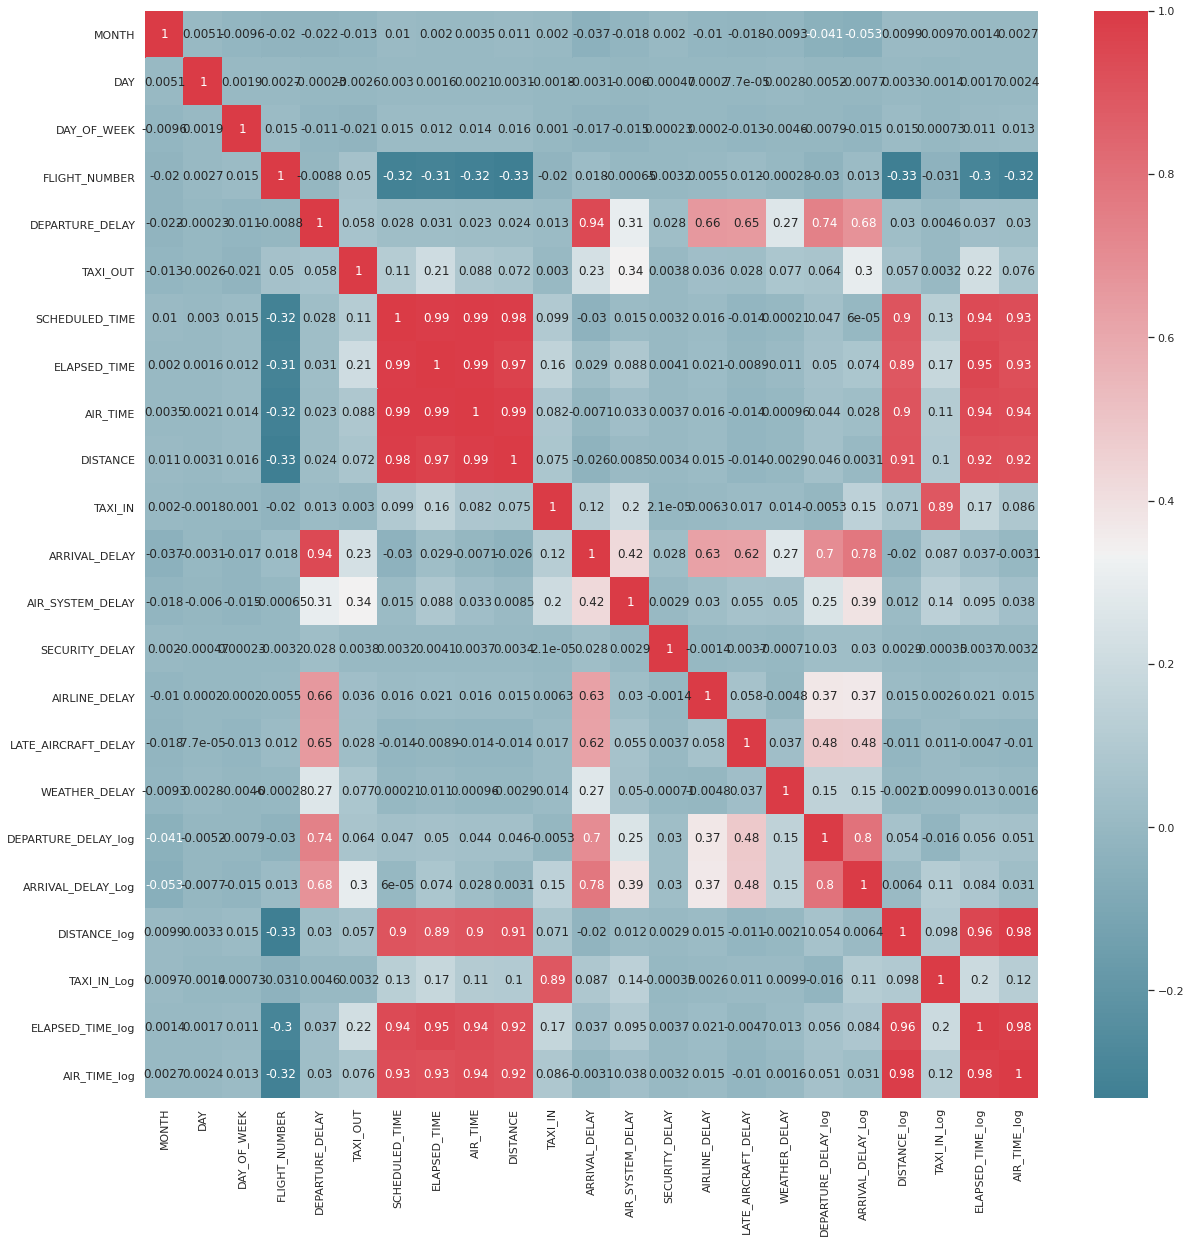

In [39]:
# Examine correlation visually using Seaborn. (Code adapted from 02. Data Visualization.ipynb)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

#subset for continuous variables only
num = df_OHE[['MONTH', 'DAY','DAY_OF_WEEK','FLIGHT_NUMBER',
          'DEPARTURE_DELAY','TAXI_OUT','SCHEDULED_TIME',
          'ELAPSED_TIME','AIR_TIME','DISTANCE',
          'TAXI_IN','ARRIVAL_DELAY','AIR_SYSTEM_DELAY',
          'SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY', 'DEPARTURE_DELAY_log',
          'ARRIVAL_DELAY_Log', 'DISTANCE_log', 'TAXI_IN_Log','ELAPSED_TIME_log',
          'AIR_TIME_log']]

sns.heatmap(num.corr(), cmap=cmap, annot = True)

`SCHEDULED_TIME`, `ELAPSED_TIME`, `AIR_TIME`, `DISTANCE` are all highly correlated. However, for the log versions, only `DISTANCE_log`, `ELAPSED_TIME_log`, and `AIR_TIME_log` show high correlations to each other. Additionally, `DEPARTURE_DELAY` and `ARRIVAL_DELAY` for both the normal and log versions are also highly correlated.

Let's go through and remove one of each of these and re-run the corr plot.

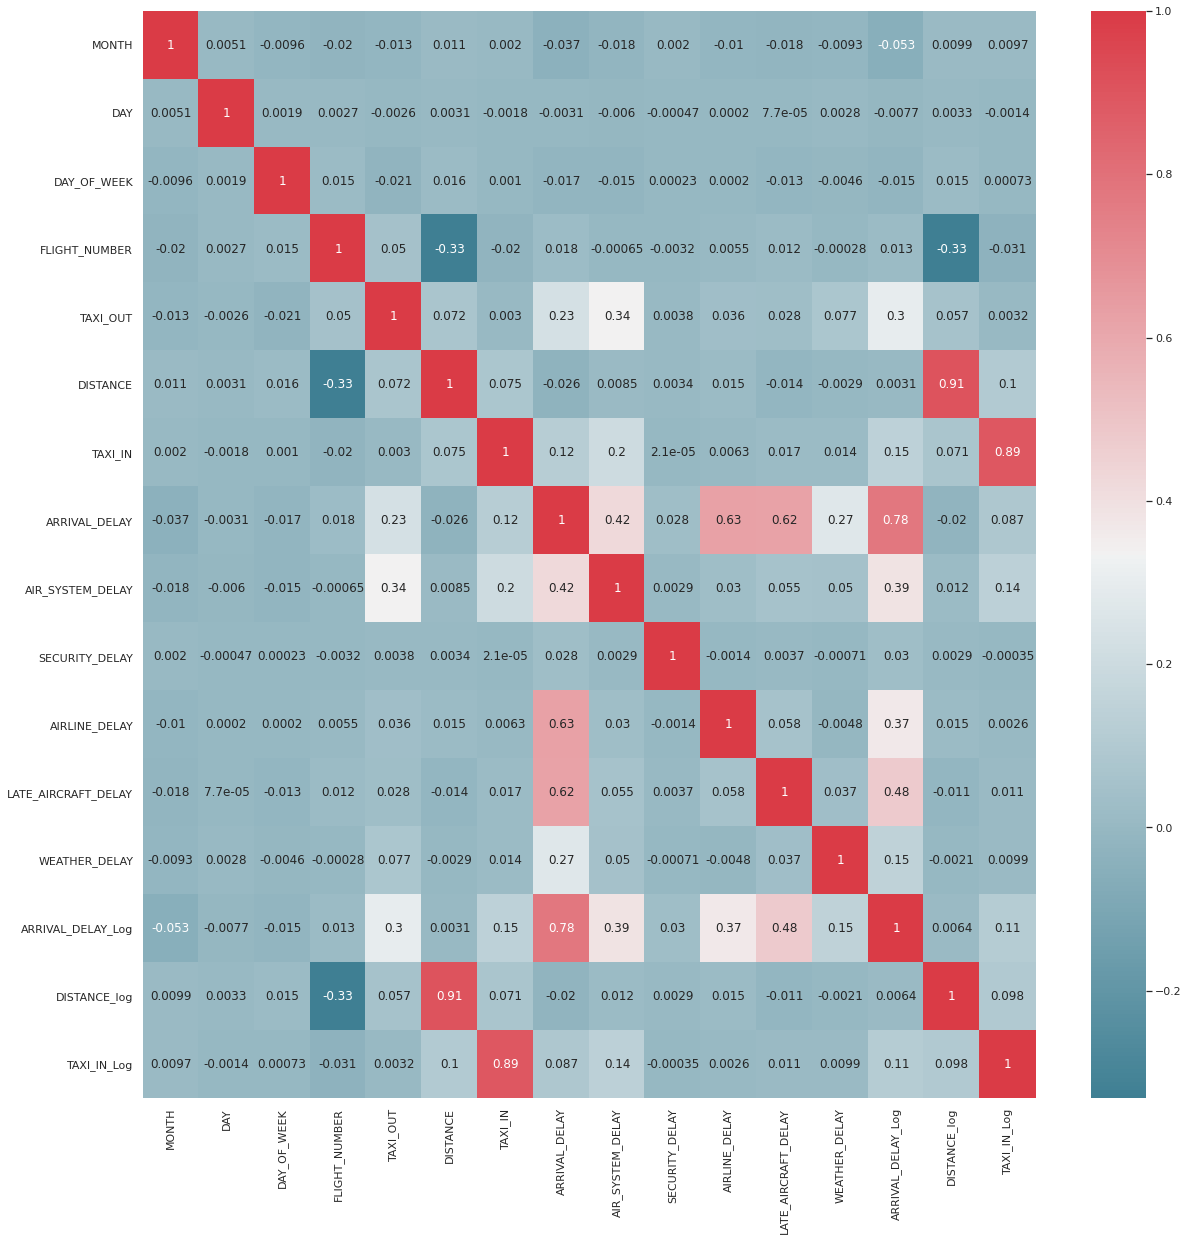

In [40]:
#drop SCHEDULED_TIME, ELAPSED_TIME, AIR_TIME, and their log versions as well as DEPARTURE_DELAY
col_to_drop2 = ['SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME',
                'ELAPSED_TIME_log', 'AIR_TIME_log', 'DEPARTURE_DELAY', 'DEPARTURE_DELAY_log']
df_OHE = df_OHE.drop(columns = col_to_drop2)

# Examine correlation visually using Seaborn. (Code adapted from 02. Data Visualization.ipynb)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

#subset for continuous variables only
num = df_OHE[['MONTH', 'DAY','DAY_OF_WEEK','FLIGHT_NUMBER',
          'TAXI_OUT','DISTANCE','TAXI_IN',
          'ARRIVAL_DELAY','AIR_SYSTEM_DELAY',
          'SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY',
          'ARRIVAL_DELAY_Log', 'DISTANCE_log', 'TAXI_IN_Log']]

sns.heatmap(num.corr(), cmap=cmap, annot = True)

In [41]:
#drop remaining highly correlated vars DISTANCE and TAXI_IN
col_to_drop3 = ['DISTANCE', 'TAXI_IN']
df_OHE = df_OHE.drop(columns = col_to_drop3)

### Test/Train Split

Our desired variable for classication will be our binary value for delay to determine whether or not a flight was delayed on arrival.

In [42]:
#move response variable to last column
cols = list(df_OHE.columns.values) 
cols.pop(cols.index('DELAYED')) 
df_final = df_OHE[cols+['DELAYED']]

In [43]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5709785 entries, 0 to 5709794
Data columns (total 58 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MONTH                            int64  
 1   DAY                              int64  
 2   DAY_OF_WEEK                      int64  
 3   FLIGHT_NUMBER                    int64  
 4   TAXI_OUT                         float64
 5   ARRIVAL_DELAY                    float64
 6   DIVERTED                         int64  
 7   AIR_SYSTEM_DELAY                 float64
 8   SECURITY_DELAY                   float64
 9   AIRLINE_DELAY                    float64
 10  LATE_AIRCRAFT_DELAY              float64
 11  WEATHER_DELAY                    float64
 12  ARRIVAL_DELAY_Log                float64
 13  DISTANCE_log                     float64
 14  TAXI_IN_Log                      float64
 15  ORIGIN_AIRPORT_encode            int64  
 16  DESTINATION_AIRPORT_encode       float64
 17  TAIL_NUM

In [18]:
#create random sample of 100,000 rows for first pass modeling
#df_small = df.sample(n=100000,random_state = 0)

In [37]:
#from sklearn.model_selection import train_test_split

#y = df_final['DELAYED'].values # get the labels we want
#X = df_final.iloc[:,0:1865].values

In [38]:
#y.shape

(100000,)

In [39]:
#X.shape

(100000, 1865)

In [41]:
#create test and train split with random seed
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 4796), (2000, 4796), (8000,), (2000,))

In [44]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'DELAYED' in df_final:
    y = df_final['DELAYED'].values # get the labels we want
    del df_final['DELAYED'] # get rid of the class label
    X = df_final.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=10, test_size=0.2, train_size=None)


### Logistic Regression

In [ ]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' )
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

### SVM

Run 'out of the box' SVM with scaling and one-hot encoding from above pipeline.

In [ ]:
#clf = make_pipeline(
#    preprocess,
#    SVC())

In [ ]:
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score

#run classifier
clf.fit(X_train, y_train)

#predict values
y_hat = clf.predict(X_test)

#calculate accuracy and confusion matrix (no cross val)
print("Accuracy:",mt.accuracy_score(y_test, y_hat))
print("Precision:",mt.precision_score(y_test, y_hat))
print("Recall:",mt.recall_score(y_test, y_hat))

Accuracy: 0.6275
Precision: 1.0
Recall: 0.015852047556142668


In [ ]:
#excluding tail number
clf = SVC()

#run classifier
clf.fit(X_train[:,0:1033], y_train)

#predict values
y_hat = clf.predict(X_test[:,0:1033])

#calculate accuracy and confusion matrix (no cross val)
print("Accuracy:",mt.accuracy_score(y_test, y_hat))
print("Precision:",mt.precision_score(y_test, y_hat))
print("Recall:",mt.recall_score(y_test, y_hat))

Accuracy: 0.6275
Precision: 1.0
Recall: 0.015852047556142668


### Removing Tail Number

The SVC without tail number did not perform differently. Because it adds 3000+ columns for one-hot encoding, let's remove it for faster processing once we model on the entire data set.

In [ ]:
y = df_OHE['DELAYED'].values # get the labels we want
X = df_OHE.iloc[:,0:1033].values

In [ ]:
#create test and train split with random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 1033), (2000, 1033), (8000,), (2000,))

In [ ]:
#try grid search

param_grid = {
    'kernel':('linear', 'rbf'),
    'C': [0.1, 1.0, 10, 100],
}

svc = SVC()
grid_search = GridSearchCV(clf, param_grid, cv=3)

In [ ]:
#run classifier
grid_search.fit(X_train, y_train)

#predict values
y_hat = grid_search.predict(X_test)

#calculate accuracy and confusion matrix (no cross val)
print("Accuracy:",mt.accuracy_score(y_test, y_hat))
print("Precision:",mt.precision_score(y_test, y_hat))
print("Recall:",mt.recall_score(y_test, y_hat))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#run classifier
clf.fit(X_train, y_train)

#predict values
y_hat = clf.predict(X_test)

#calculate accuracy and confusion matrix (no cross val)
print("Accuracy:",mt.accuracy_score(y_test, y_hat))
print("Precision:",mt.precision_score(y_test, y_hat))
print("Recall:",mt.recall_score(y_test, y_hat))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.954
Precision: 0.9548563611491108
Recall: 0.9220607661822986


## Advantages of Each Model

[10 points] Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

## Feature Importance

[30 points] Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation in detail. Why do you think some variables are more important?

## Support Vectors

[10 points] Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain.